# Sports Activity Detection

#### 1. Download Dataset and Understand the Format

In [7]:
import numpy as np
import pandas as pd
import sklearn as sk
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [9]:
# # from google.colab import drive

# # drive.mount('/content/drive')

# # data_path = '/content/drive/My Drive/data'

# data_path = 'C:/Users/dell/Downloads/daily+and+sports+activities/data'
data_path = 'data'

def preprocess_and_reduce_dimension(data_path):
    X_train_means, X_val_means = [], []
    X_train_flattened, X_val_flattened = [], []
    y_val = []

    for activity_folder in os.listdir(data_path):
        if '.DS_Store' in activity_folder: continue
        activity_folder_path = os.path.join(data_path, activity_folder)
        activity_label = int(activity_folder[1:])  # Extract the numeric part from the folder name
        for subject_folder in os.listdir(activity_folder_path):
            subject_folder_path = os.path.join(activity_folder_path, subject_folder)
            segment_files = os.listdir(subject_folder_path)
            for i, segment_file in enumerate(segment_files):
                segment_file_path = os.path.join(subject_folder_path, segment_file)
                segment_data = np.loadtxt(segment_file_path, delimiter=',')

                if i < 48:
                    # Considering only training data
                    segment_mean = np.mean(segment_data, axis=0)
                    X_train_means.append(segment_mean)
                    segment_flattened = segment_data.flatten()
                    X_train_flattened.append(segment_flattened)
                else:
                    # Consider only validation data
                    segment_mean = np.mean(segment_data, axis=0)
                    X_val_means.append(segment_mean)
                    segment_flattened = segment_data.flatten()
                    X_val_flattened.append(segment_flattened)
                    y_val.append(activity_label)

    X_train_means = np.array(X_train_means)
    X_val_means = np.array(X_val_means)
    X_train_flattened = np.array(X_train_flattened)
    X_val_flattened = np.array(X_val_flattened)
    y_val = np.array(y_val)

    #reducing dimensions using pca
    pca=PCA(n_components=1000)
    X_train_flattened=pca.fit_transform(X_train_flattened)
    X_val_flattened=pca.transform(X_val_flattened)


    return X_train_means, X_val_means, X_train_flattened, X_val_flattened, y_val

X_train_means, X_val_means, X_train_flattened, X_val_flattened, y_val = preprocess_and_reduce_dimension(data_path)

print("Mean-based Preprocessed Training Data Shape:", X_train_means.shape)
print("Mean-based Preprocessed Validation Data Shape:", X_val_means.shape)
print("Flattened Preprocessed Training Data Shape:", X_train_flattened.shape)
print("Flattened Preprocessed Validation Data Shape:", X_val_flattened.shape)
print("Validation Labels Shape:", y_val.shape)

# np.set_printoptions(threshold=np.inf)
# print(y_val)




Mean-based Preprocessed Training Data Shape: (7296, 45)
Mean-based Preprocessed Validation Data Shape: (1824, 45)
Flattened Preprocessed Training Data Shape: (7296, 1000)
Flattened Preprocessed Validation Data Shape: (1824, 1000)
Validation Labels Shape: (1824,)


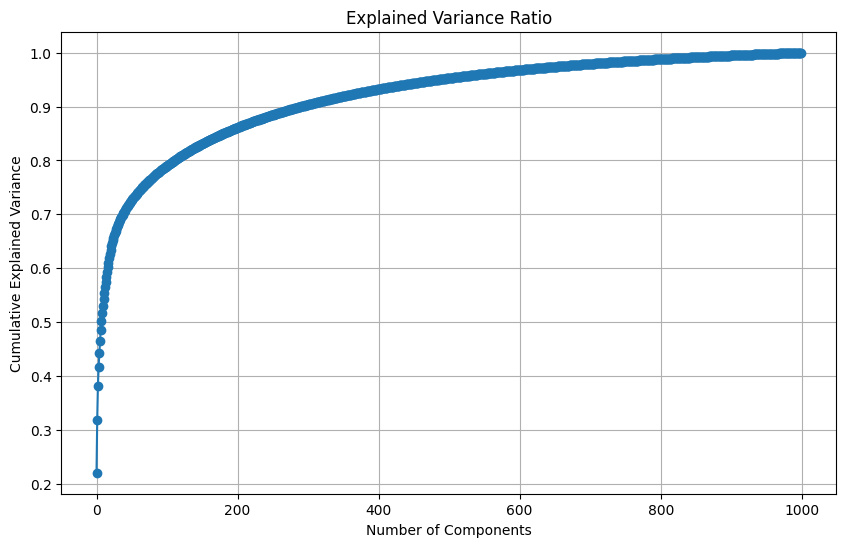

Optimal number of components for 95% variance: 485
(7296, 485)


In [10]:
cov_matrix = np.cov(X_train_flattened, rowvar=False)
pca = PCA()
pca.fit(X_train_flattened)

plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio')
plt.grid(True)
plt.show()

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
optimal_num_components = np.argmax(cumulative_variance >= 0.95) + 1
print("Optimal number of components for 95% variance:",optimal_num_components)

pca_optimal = PCA(n_components=optimal_num_components)
X_train_flattened= pca_optimal.fit_transform(X_train_flattened)
print(X_train_flattened.shape)


#### 2. Clustering Using K-Means


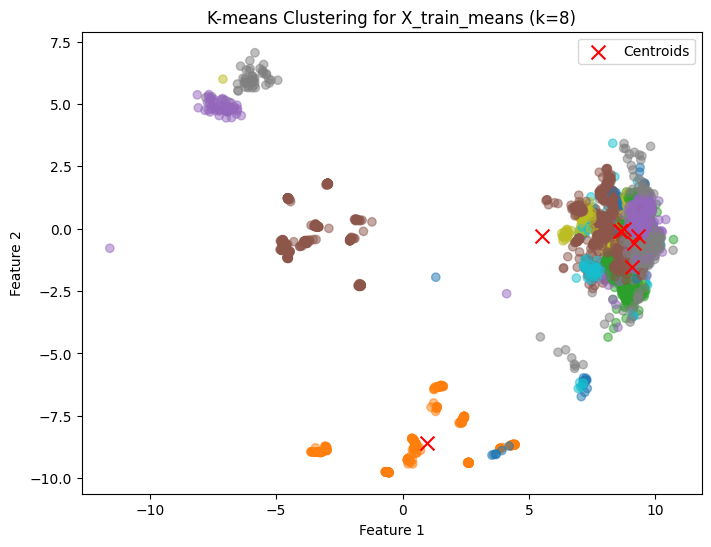

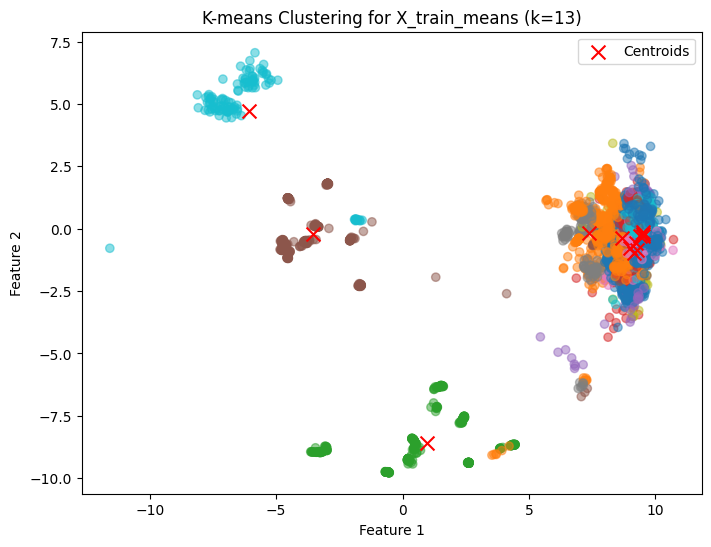

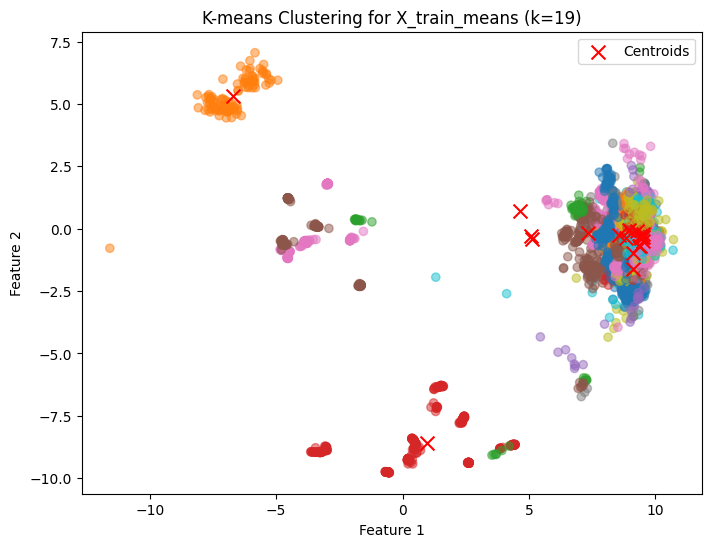

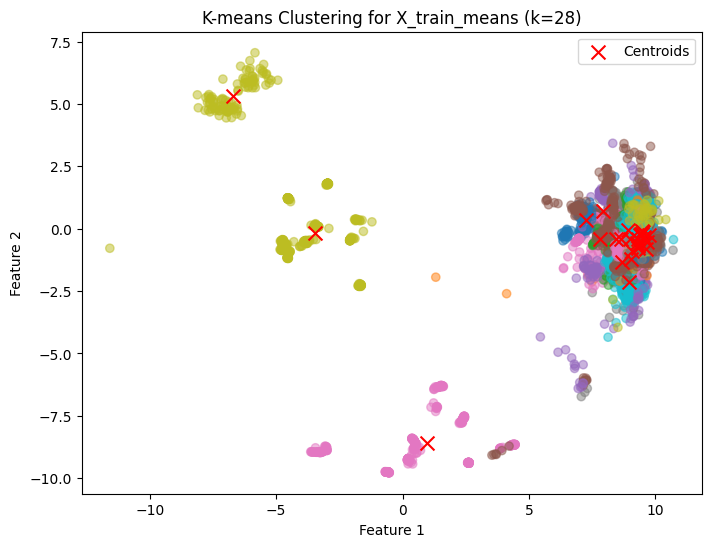

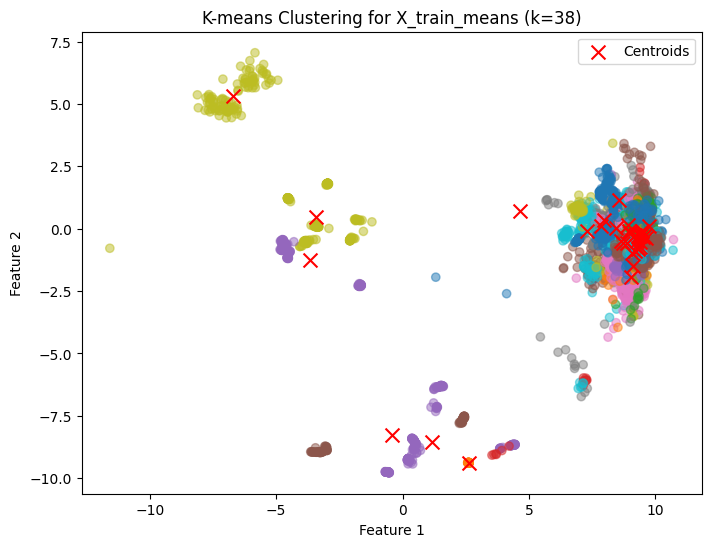

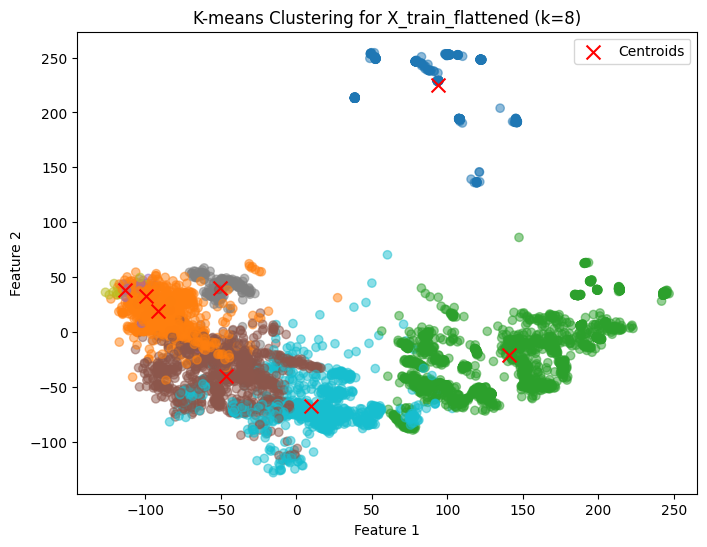

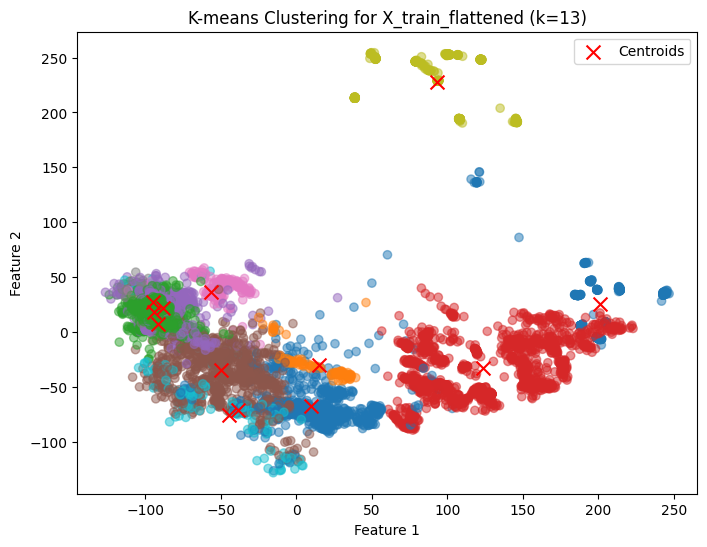

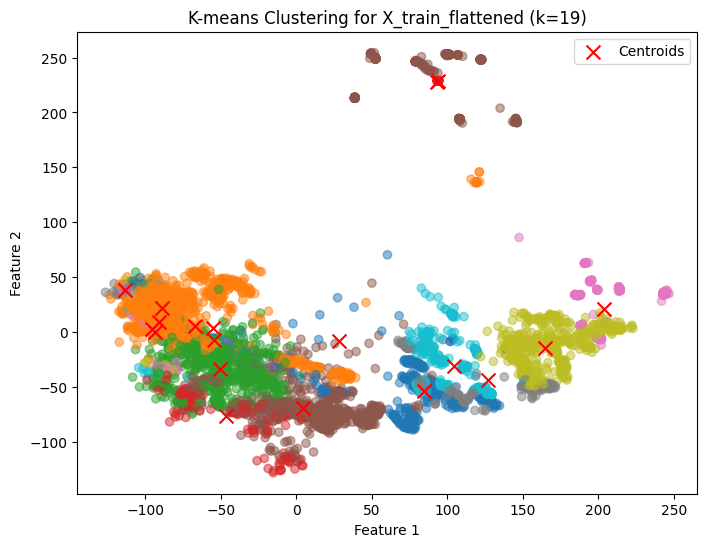

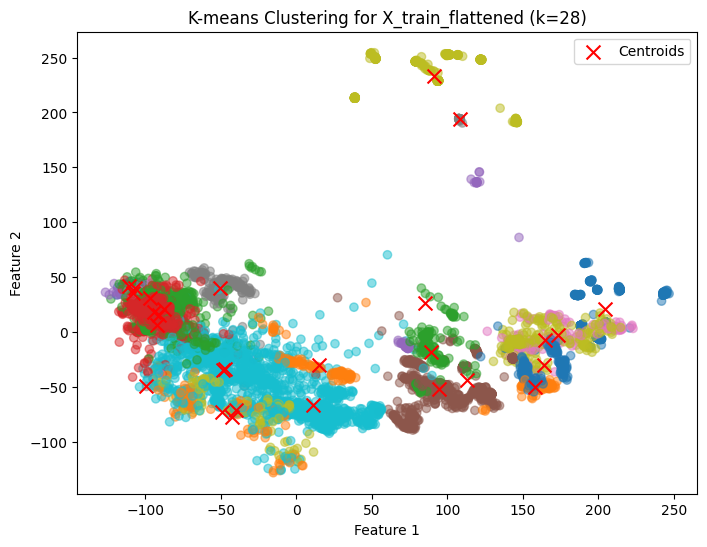

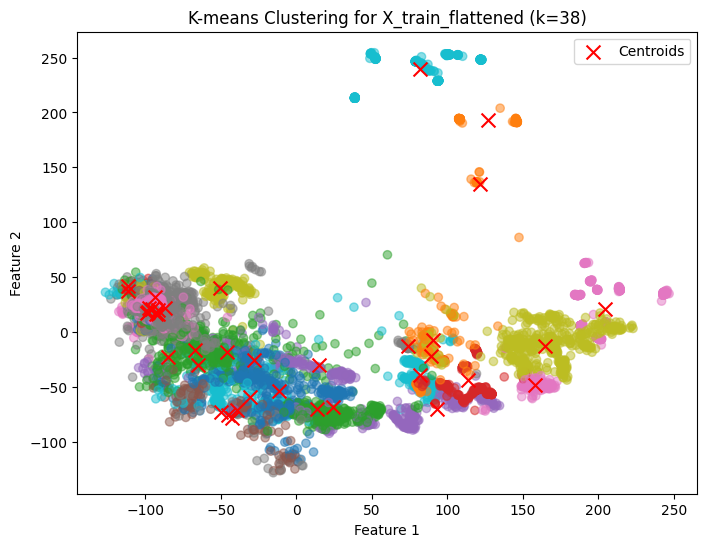

In [11]:
def kmeans(X,n_clusters,max_iter=300):
    centroids = X[np.random.choice(X.shape[0],n_clusters,replace=False)]
    for _ in range(max_iter):
        distances =np.sqrt(((X - centroids[:,np.newaxis])**2).sum(axis=2))
        labels=np.argmin(distances, axis=0)
        new_centroids=np.zeros_like(centroids)
        for i in range(n_clusters):
            new_centroids[i]=np.mean(X[labels == i], axis=0)
        if np.allclose(centroids, new_centroids):
            break  
        centroids = new_centroids
    return labels, centroids

k_values = [8, 13, 19, 28, 38]
datasets = [(X_train_means, 'X_train_means'), (X_train_flattened, 'X_train_flattened')]

#visualizing 2 attributes for visualization
for X, dataset_name in datasets:
    for k in k_values:
        labels,centroids=kmeans(X,k)
        plt.figure(figsize=(8,6))
        plt.scatter(X[:,0], X[:,1],c=labels,cmap='tab10',alpha=0.5)
        plt.scatter(centroids[:, 0], centroids[:,1], c='red',marker='x',s=100, label='Centroids')
        plt.title(f'K-means Clustering for {dataset_name} (k={k})')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.show()


#### 1. Download Dataset and Understand the Format

#### 3. Clustering Using Normalized Cut

In [18]:
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
import networkx as nx

def normalized_cut(X, n_clusters):
    dist_matrix = pairwise_distances(X, metric='euclidean')
    similarity_matrix = np.exp(-dist_matrix ** 2 / (2. * np.std(dist_matrix) ** 2))
    G = nx.from_numpy_array(similarity_matrix)
    D = np.diag(np.array(G.degree(weight='weight'))[:, -1])
    L = nx.laplacian_matrix(G).toarray()
    D_sqrt_inv = np.linalg.inv(np.sqrt(D))
    normalized_laplacian = np.dot(D_sqrt_inv, np.dot(L, D_sqrt_inv))
    eigenvalues, eigenvectors = np.linalg.eig(normalized_laplacian)
    k_smallest = eigenvectors[:, :n_clusters]
    k_smallest_normalized = np.divide(k_smallest, np.apply_along_axis(np.linalg.norm, 1, k_smallest)[:, np.newaxis])
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(k_smallest_normalized)
    return kmeans.labels_

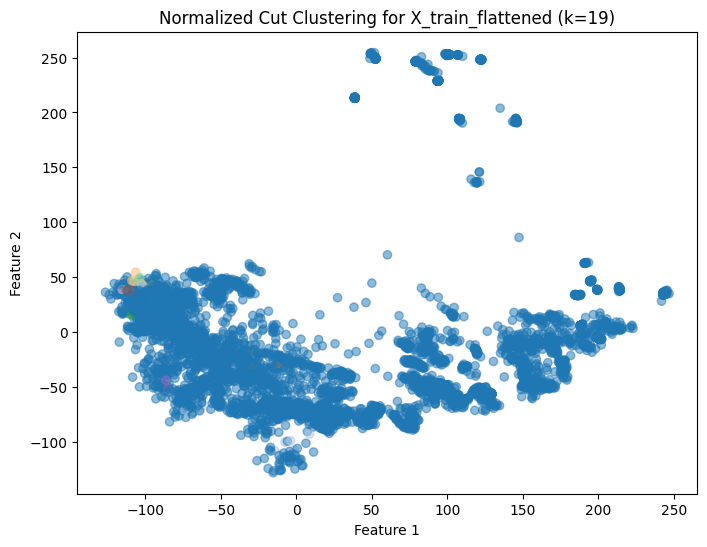

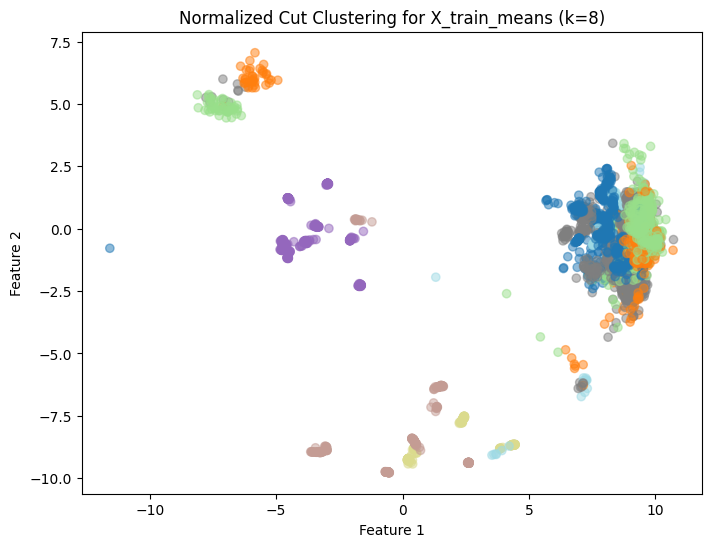

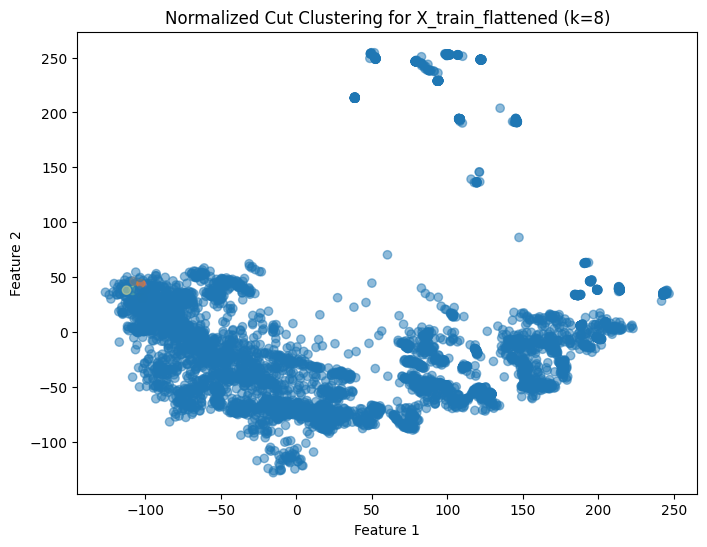

In [20]:
k_values = [8, 13, 19, 28, 38]
datasets = [(X_train_means, 'X_train_means'), (X_train_flattened, 'X_train_flattened')]

#visualizing 2 attributes for visualization
for X, dataset_name in datasets:
    for k in k_values:
        labels = normalized_cut(X, k)
        plt.figure(figsize=(8,6))
        plt.scatter(X[:,0], X[:,1],c=labels,cmap='tab20',alpha=0.5)
        plt.title(f'Normalized Cut Clustering for {dataset_name} (k={k})')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()


#### 4. Evaluation

In [ ]:
# Precision

In [ ]:
# Recall

In [ ]:
# F1 Score

In [ ]:
# Conditional Entropy

#### 5. New Clustering Algorithm